In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.font_manager as fm

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sc_params = {u'AheadBehind': u'',
 u'ClutchTime': u'',
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': u'',
 u'DateTo': u'',
 u'EndPeriod': u'',
 u'EndRange': u'',
 u'GameID': u'',
 u'GameSegment': u'',
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': u'',
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': u'',
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': u'',
 u'Position': u'',
 u'RangeType': u'',
 u'RookieYear': u'',
 u'Season': u'2015-16',
 u'SeasonSegment': u'',
 u'SeasonType': u'Regular Season',
 u'StartPeriod': u'',
 u'StartRange': u'',
 u'TeamID': 0,
 u'VsConference': u'',
 u'VsDivision': u''}

baseurl = 'http://stats.nba.com/stats/shotchartdetail?'
resp2 = requests.get(baseurl,params=sc_params)
print resp2.url
print resp2.json().keys()

http://stats.nba.com/stats/shotchartdetail?PlayerID=0&StartPeriod=&StartRange=&TeamID=0&VsConference=&Location=&SeasonType=Regular+Season&RangeType=&RookieYear=&Season=2015-16&DateFrom=&ClutchTime=&EndPeriod=&EndRange=&ContextFilter=&GameID=&OpponentTeamID=0&DateTo=&GameSegment=&AheadBehind=&PointDiff=&LastNGames=0&VsDivision=&LeagueID=00&Position=&Outcome=&ContextMeasure=FGA&SeasonSegment=&Period=0&Month=0
[u'resource', u'resultSets', u'parameters']


In [3]:
player_shot_df = pd.DataFrame(resp2.json()['resultSets'][0]['rowSet'],columns=resp2.json()['resultSets'][0]['headers'])
print player_shot_df.shape
player_shot_df.head(5)

(40077, 21)


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500001,2,203083,Andre Drummond,1610612765,Detroit Pistons,1,11,41,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-17,-6,1,0
1,Shot Chart Detail,0021500001,5,202694,Marcus Morris,1610612765,Detroit Pistons,1,11,21,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,117,67,1,1
2,Shot Chart Detail,0021500001,6,200794,Paul Millsap,1610612737,Atlanta Hawks,1,11,0,Made Shot,Step Back Jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side(R),8-16 ft.,12,76,95,1,1
3,Shot Chart Detail,0021500001,7,203484,Kentavious Caldwell-Pope,1610612765,Detroit Pistons,1,10,44,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-68,51,1,1
4,Shot Chart Detail,0021500001,8,201143,Al Horford,1610612737,Atlanta Hawks,1,10,27,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-117,164,1,0


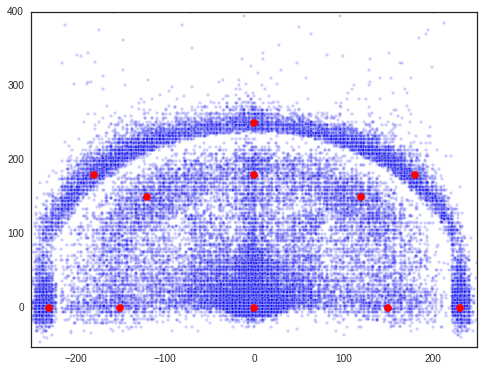

In [4]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 6))
scat = plt.scatter(x=player_shot_df.LOC_X,y=player_shot_df.LOC_Y,s=10, alpha=.2,zorder=0)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
clust_cent = np.array([[-230,0],[-150,0],[-120,150],[0,0],[-180,180],[0,180],[0,250],[120,150],[180,180],[150,0],[230,0]])
plt.scatter(clust_cent[:,0],clust_cent[:,1],s=50,color='r')
plt.show()

[[-104.40108288   38.4664723 ]
 [-103.32590943  215.98812175]
 [  -1.39921569   12.02      ]
 [ -12.25105243  120.63528511]
 [ 103.37824747  135.32672831]
 [  92.08813559   32.34576271]
 [-220.00561272   17.02899906]
 [-172.38863557  151.14310768]
 [  22.94883204  243.07675195]
 [ 154.97529967  193.82782419]
 [ 212.61028771   27.28160418]]


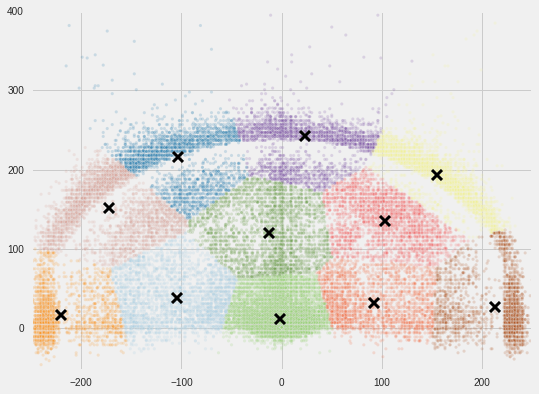

In [42]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
all_shot_df = player_shot_df[xyfields]

clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0],[-230,0],[-180,180],[0,250],[180,180],[230,0]])

kmeansall = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeansall.fit(all_shot_df)
print kmeansall.cluster_centers_

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(all_shot_df['LOC_X'],all_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeansall.labels_.astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
plt.scatter(kmeansall.cluster_centers_[:,0],kmeansall.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

[[-136.32928803   31.15291262]
 [-106.71563981  137.26023266]
 [  -1.10445114   15.54329964]
 [   1.47523962  158.44848243]
 [ 104.88508065  134.20040323]
 [ 133.24047059   29.24941176]]


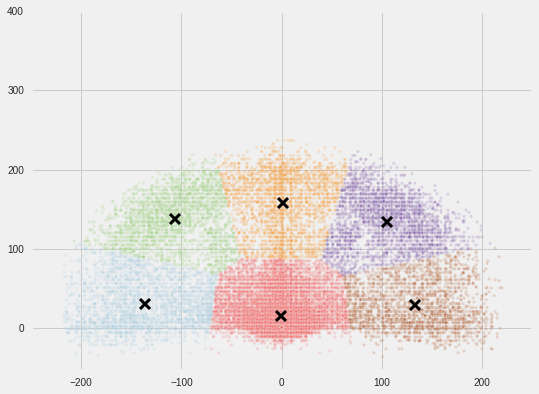

In [44]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
twoPT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='2PT Field Goal',xyfields]

clust_cent = np.array([[-150,0],[-120,150],[0,0],[0,180],[120,150],[150,0]])

kmeans = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeans.fit(twoPT_shot_df)
print kmeans.cluster_centers_

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(twoPT_shot_df['LOC_X'],twoPT_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeans.labels_.astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

[[-234.85403178   27.78516775]
 [-158.77469553  198.38734777]
 [  -1.30430839  260.54376417]
 [ 149.1512665   200.54405994]
 [ 229.77742947   28.86269592]]


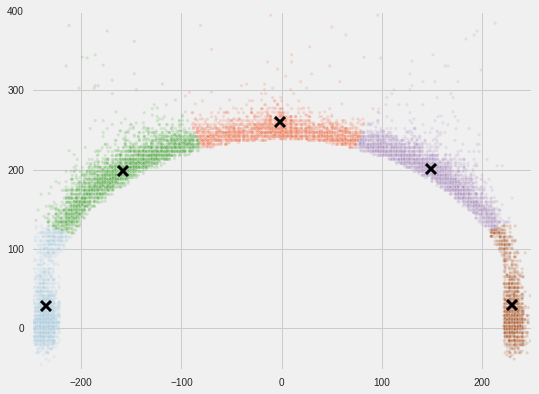

In [46]:
from sklearn import metrics
from sklearn.cluster import KMeans
xyfields = ['LOC_X','LOC_Y']
threePT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='3PT Field Goal',xyfields]

clust_cent = np.array([[-230,0],[-200,150],[0,250],[200,150],[230,0]])

kmeans3pt = KMeans(init=clust_cent,n_clusters=len(clust_cent),n_init=1)
kmeans3pt.fit(threePT_shot_df)
print kmeans3pt.cluster_centers_

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(threePT_shot_df['LOC_X'],threePT_shot_df['LOC_Y'],alpha=.2,s=10,c=kmeans3pt.labels_.astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
plt.scatter(kmeans3pt.cluster_centers_[:,0],kmeans3pt.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

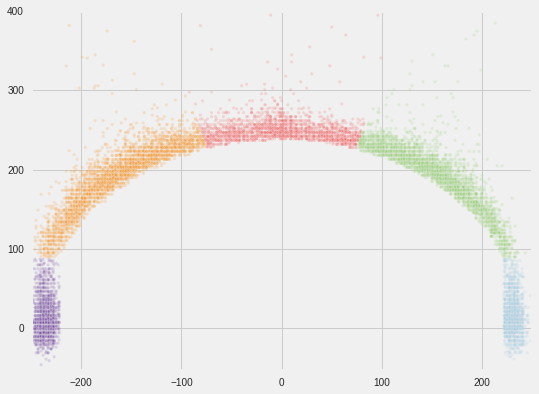

In [51]:
xyfields = ['LOC_X','LOC_Y','SHOT_ZONE_AREA']
threePT_shot_df = player_shot_df.loc[player_shot_df['SHOT_TYPE']=='3PT Field Goal',xyfields]

za_codes={'Right Side(R)':0,'Right Side Center(RC)':1,'Center(C)':2,
          'Left Side Center(LC)':3,'Left Side(L)':4,'Back Court(BC)':5}
threePT_shot_df['ZA_num']=threePT_shot_df['SHOT_ZONE_AREA'].map(lambda x: za_codes[x])
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8, 6))
plt.scatter(threePT_shot_df['LOC_X'],threePT_shot_df['LOC_Y'],alpha=.2,s=10,
            c=threePT_shot_df['ZA_num'].astype(np.float),cmap=plt.cm.Paired)
plt.xlim(-250,250)
plt.ylim(-52.5,400)
#plt.scatter(kmeans3pt.cluster_centers_[:,0],kmeans3pt.cluster_centers_[:,1],s=100,linewidths=3,color='k',marker='x')
plt.show()

In [ ]:
from matplotlib.patches import Rectangle, Circle, Arc
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import copy
clr='red'

def left_court_patches(clr='red'):
    # creates the patches for the left hand side of an nba court
    # returns: list of patches
    rim = Circle((5.25,-25),radius=.75, color=clr, zorder=0, lw=.5, fill=False)
    bkbrd = Rectangle((4,-28),width=0, height=6, color=clr, zorder=0,fill=False,lw=1)
    ra_arc = Arc((5.25,-25),8,8,theta1=270,theta2=90,color=clr,zorder=9,fill=False,lw=1)
    ra_t = Rectangle((4,-21),width=1.25,height=0,color=clr, zorder=0,fill=False,lw=1)
    ra_b = Rectangle((4,-29),width=1.25,height=0,color=clr, zorder=0,fill=False,lw=1)
    ft = Rectangle((0,-33),width=19,height=16,color=clr, zorder=0,fill=False,lw=1) #*16ft. outside
    lane = Rectangle((0,-31),width=19,height=12,color=clr,zorder=0,fill=False,lw=1)#*12ft. outside
    ft_ia = Arc((19,-25),12,12,theta1=90,theta2=270,color=clr,zorder=9,fill=False,lw=1,linestyle='--')
    ft_oa = Arc((19,-25),12,12,theta1=270,theta2=90,color=clr,zorder=9,fill=False,lw=1)
    three_t = Rectangle((0,-3),width=14,height=0,color=clr,zorder=0,fill=False,lw=1)
    three_b = Rectangle((0,-47),width=14,height=0,color=clr,zorder=0,fill=False,lw=1)
    three_arc = Arc((5.25,-25),23.75*2,23.75*2,theta1=292,theta2=68,color=clr,zorder=0,fill=False,lw=1)
    return [rim,bkbrd,ra_arc,ra_t,ra_b,ft,lane,ft_ia,ft_oa,three_t,three_b,three_arc]

def draw_full_court(ax=None,clr='red'):
    # Draws full court onto axis
    # returns: axis
    if ax is None:
        ax = plt.gca()
        
    #full court components 
    fullcourt = Rectangle((0,-50), width=94, height=50, color=clr, zorder=0,fill=False,lw=1) #base and side lines
    midcourt = Rectangle((47,-50), width=0, height=50, color = clr, zorder=0,fill=False,lw=1) #half-court line
    rest_circ = Circle((47,-25),radius=2,color=clr,zorder=0,lw=1,fill=False) #restraining circle
    cent_circ = Circle((47,-25),radius=6,color=clr,zorder=0,lw=1,fill=False) #center circle
    patch_list = [fullcourt,midcourt,rest_circ,cent_circ]
    for patch in patch_list:
        ax.add_patch(patch)
    
    #left-hand side
    left_patches = left_court_patches(clr=clr)
    for patch in left_patches:
        ax.add_patch(patch)

    #right-hand side transform patches by rotating pi radians around center point
    right_patches = left_court_patches(clr=clr)
    tr = mpl.transforms.Affine2D().rotate_around(47,-25,np.pi) + ax.transData
    for patch in right_patches:
        patch.set_transform(tr)
        ax.add_patch(patch)
    return ax

plt.style.use('seaborn-white')
fig,ax = plt.subplots(figsize=(9.4,5.0))
draw_full_court()

plt.xlim(0,94)
plt.ylim(-50,0)
plt.show()

In [ ]:
ZAs = player_shot_df.SHOT_ZONE_AREA.unique()
ZRs = player_shot_df.SHOT_ZONE_RANGE.unique()[:-1] #-1 to avoid Backcourt shots

fig,ax = plt.subplots(figsize=(12, 12))
colrs = np.random.random((len(ZAs)*len(ZRs),4))
cmap = plt.get_cmap()
print cmap.N
cnum=0
for za in ZAs:
    for zr in ZRs:
        bin_mask = (player_shot_df['SHOT_ZONE_AREA']==za) & (player_shot_df['SHOT_ZONE_RANGE']==zr)
        if np.sum(bin_mask) > 0:
            cnum+=1
            plt.scatter(x=player_shot_df[bin_mask]['LOC_X'],y=player_shot_df[bin_mask]['LOC_Y'],c=colrs[cnum],
             s=5, alpha=.7, edgecolors='none', zorder=2,label=za+zr)
ax.invert_yaxis()

#Read in the half court image
plt.style.use('grayscale')
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])
plt.title('All NBA Shots Attempts by Shot Zone and Range 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotzonerange_2015-16.png',dpi=300)
plt.show